In [83]:
!pip install pyarrow
!pip install fastparquet
!pip install gensim

### Overview

In this notebook, I would like to present a framework for **partitioned validation** using one-week hold out.  
As an example of possible groupings of customers, here I choose '**online vs. offline**', which shows that it is more difficult to predict future purchases of offline uses than to predict those of online users.  
  
I use some tequniqus I learned from great discussions and notebooks shared in the H&M competition.  
So, I would really like to thank all the authors of them.

- **Version 6**  
I added and fixed the code so as to make it easier to record and show results of validations on the week from 2020-9-16 to 2020-9-22.  
In Version 6, MAP@12 of hold-out validation is around 0.0183 for online users and 0.0298 for offline users.  

### Libraries and Functions

In [84]:
import numpy as np, pandas as pd, datetime as dt
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
from collections import defaultdict

def iter_to_str(iterable):
    return " ".join(map(lambda x: str(0) + str(x), iterable))

def apk(actual, predicted, k=12):
    if len(predicted) > k:
        predicted = predicted[:k]
    score, nhits = 0.0, 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            nhits += 1.0
            score += nhits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=12, return_apks=False):
    assert len(actual) == len(predicted)
    apks = [apk(ac, pr, k) for ac, pr in zip(actual, predicted) if 0 < len(ac)]
    if return_apks:
        return apks
    return np.mean(apks)

def blend(dt, w=[], k=12):
    if len(w) == 0:
        w = [1] * (len(dt))
    preds = []
    for i in range(len(w)):
        preds.append(dt[i].split())
    res = {}
    for i in range(len(preds)):
        if w[i] < 0:
            continue
        for n, v in enumerate(preds[i]):
            if v in res:
                res[v] += (w[i] / (n + 1))
            else:
                res[v] = (w[i] / (n + 1))    
    res = list(dict(sorted(res.items(), key=lambda item: -item[1])).keys())
    return ' '.join(res[:k])

def prune(pred, ok_set, k=12):
    pred = pred.split()
    post = []
    for item in pred:
        if int(item) in ok_set and not item in post:
            post.append(item)
    return " ".join(post[:k])

def validation(actual, predicted, grouping, score=0, index=-1, ignore=False, figsize=(12, 6)):
    # actual, predicted : list of lists
    # group : pandas Series
    # score : pandas DataFrame
    
    vc = pd.Series(predicted).apply(len).value_counts()
    print("Fill Rate = ", round(1 - sum(vc[k] * (12 - k) / 12 for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100)
    
    
    if ignore: return
    ap12 = mapk(actual, predicted, return_apks=True)
    map12 = round(np.mean(ap12), 6)
    if isinstance(score, int): score = pd.DataFrame({g:[] for g in sorted(grouping.unique().tolist())})
    if index == -1 : index = score.shape[0]
    score.loc[index, "All"] = map12
    plt.figure(figsize=figsize)
    plt.subplot(1, 2, 1); sns.histplot(data=ap12, log_scale=(0, 10), bins=20); plt.title(f"MAP@12 : {map12}")
    for g in grouping.unique():
        map12 = round(mapk(actual[grouping == g], predicted[grouping == g]), 6)
        score.loc[index, g] = map12
    plt.subplot(1, 2, 2); score[[g for g in grouping.unique()[::-1]] + ['All']].loc[index].plot.barh(); plt.title(f"MAP@12 of Groups")
    vc = pd.Series(predicted).apply(len).value_counts()
    score.loc[index, "Fill"] = round(1 - sum(vc[k] * (12 - k) / 12 for k in (set(range(12)) & set(vc.index))) / len(actual), 3) * 100
    display(score)
    return score

In [85]:
from tqdm import tqdm

def sort_item2vec(colname, max_n = 2, none = "") :
    l = []
    for i in tqdm(range(len(sub))) :
        wid = sub.iloc[i]['customer_id']
        oc = sub.iloc[i][colname].split()
        if len(oc) == 0 :
            l.append(none)
        elif wid not in cust_buy :
            l.append(" ".join(oc))            
        elif len(oc) <= 1 :
            l.append(" ".join(oc))
        else :
            ll = []
            for e in oc : 
                buy = cust_buy[wid].split(" ")
                p = model.wv.similarity(buy, e).mean()
                ll.append([p, e])
            ll.sort(reverse=True)
            l.append(" ".join(list(map(lambda x: x[1], ll[:max_n]))))
    #     if i == 10: break

    return l


def cut_items(name, n = 12) :
    l = []
    for i in tqdm(range(len(sub))) :
        s = sub[name][i].split(" ")
        l.append(" ".join(s[:n]))
    return l

In [87]:
val_week = 104
use_item2vec = True
is_load = True
is_save = False

### wod2vec

In [88]:
import json
from  gensim import models

if val_week == 104 :
    print("item2vec = 104")
    model = models.Word2Vec.load('../input/handmitem2vec/word2vec_v2_week104.model')
    with open('../input/handmitem2vec/cust_buy104.json', "r") as f :
        cust_buy = json.load(f)
else :
    print("item2vec = 105")
    model = models.Word2Vec.load('../input/handmitem2vec/word2vec_v2.model')
    with open('../input/handmitem2vec/cust_buy.json', "r") as f :
        cust_buy = json.load(f)


item2vec = 104


### Data

In [89]:
df = pd.read_parquet('../input/hm-parquets-of-datasets/transactions_train.parquet')
sub = pd.read_csv('../input/h-and-m-personalized-fashion-recommendations/sample_submission.csv')
cid = pd.DataFrame(sub.customer_id.apply(lambda s: int(s[-16:], 16)))

### Kangol x H&Mを除外（val_weekが105の場合）

In [90]:
# if val_week == 105 :
#     print("remove Kangol x H&M")
#     articles_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv",dtype=str, encoding='utf8')
#     xHM = []
#     for i, e in enumerate(articles_df['detail_desc'].fillna("")) :
#         if 'Kangol x H&M' in e:
#             #print(articles_df.iloc[i]['article_id'], e)
#             xHM.append(int(articles_df.iloc[i]['article_id']))

#     #xHM
#     df = df[~df.article_id.isin(xHM)]

### Definition of Groups

In [91]:
group = df.groupby('customer_id').sales_channel_id.mean().round().reset_index()\
    .merge(cid, on='customer_id', how='right').rename(columns={'sales_channel_id':'group'})
grouping = group.group.fillna(1.0)

### One-Week Hold Out

In [92]:
# id of week to be used in a validation; set 105 if you would like to create a submission
val = df.loc[df.week == val_week].groupby('customer_id').article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right')
actual = val.article_id.apply(lambda s: [] if pd.isna(s) else s.split())
last_date = df.loc[df.week < val_week].t_dat.max()

In [93]:
last_date

Timestamp('2020-09-15 00:00:00')

## load Result

LOAD...
Fill Rate =  28.7


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7


,customer_id,prediction,last_purchase,other_colors,trend_items,trend_items2,trend_ageatt,trend_woman,popular_items
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,0568601043,0568601006,0900279001 0919273002 0762846006 0915529003 09...,0919273002 0915529003 0914805002 0751471001 08...,0884319002 0919273002 0909371001 0915529003 08...,0884319002 0919273002 0909371001 0915529003 08...,0568601006
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,0826211002,,0448509014 0809238001 0706016001 0809238005 08...,0448509014 0809238001 0809238005 0751471001 08...,0448509014 0809238001 0809238005 0158340001 07...,0448509014 0809238001 0809238005 0158340001 07...,0673677002 0658298001
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,0794321007,0794321011,0762846027 0809238005 0751471001 0896169005 08...,0762846027 0809238005 0751471001 0896169005 09...,0762846027 0809238005 0751471001 0918525001 08...,0762846027 0809238005 0751471001 0918525001 08...,
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,0742079001 0732413001,,0751471001 0809238001 0706016003 0673677002 09...,0861803009 0869331006 0805000008 0912204001 08...,0805000008 0912204001 0805000001 0730683019 06...,,
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,0791587015 0927530004 0730683050 0896152002,0730683062 0927530006 0791587001 0896152001,0809238001 0914805002 0751471043 0900267001 09...,0919273002 0915529003 0809238001 0914805002 08...,0896152002 0914805002 0896169005 0896169002 07...,0896152002 0914805002 0896169005 0896169002 07...,
...,...,...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0706016001 0706016002 0372860001 0610776002 07...,0713997002 0720125039 0740922009 0791587007 08...,0557599023 0791587015 0720125007 0740922001 08...,0896169005 0898713001 0809238001 0448509014 08...,0896169005 0809238001 0448509014 0863583001 08...,0809238001 0448509014 0863583001 0809238005 01...,0809238001 0448509014 0863583001 0809238005 01...,0253448003
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0706016001 0706016002 0372860001 0610776002 07...,0762846031 0853654012 0624486088 0853654002 07...,0624486001 0762846027 0759871025 0853654001,0805947001 0706016002 0706016001 0762846027 04...,0767423001 0805947001 0706016002 0706016001 04...,0805947001 0818754004 0706016002 0706016001 08...,,0624486001 0507909001
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016001 0706016002 0372860001 0610776002 07...,0762846027 0689365050 0794819001 0884081001,0884081002 0762846031 0794819003 0689365045,0781613006 0706016001 0706016002 0915526001 08...,0805947001 0448509014 0751471001 0762846027 09...,0805947001 0448509014 0751471001 0762846027 09...,0805947001 0448509014 0751471001 0762846027 09...,0636323002
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0706016001 0706016002 0372860001 0610776002 07...,0882810001,0882810004,0714790020 0448509014 0715624010 0706016002 08...,0714790020 0448509014 0870328003 0767423011 07...,0874113005 0448509014 0870328003 0893432005 07...,,


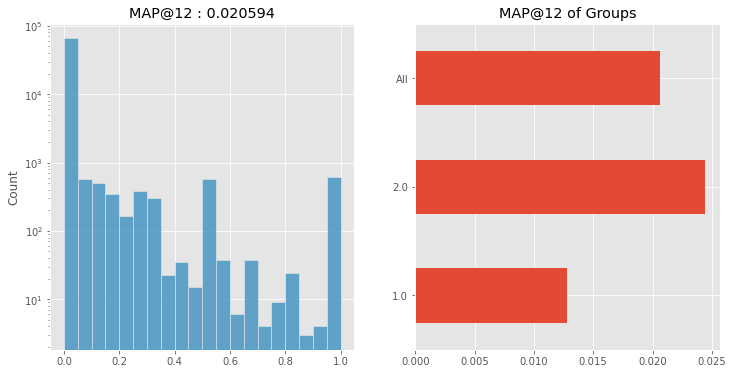

In [94]:
if is_load :
    print("LOAD...")
    if val_week == 105: 
        sub = pd.read_parquet('submission_all.parquet')
    else :
        sub = pd.read_parquet('submission_all_104.parquet')
    predicted = sub['last_purchase'].apply(lambda s: [] if pd.isna(s) else s.split())
    score = validation(actual, predicted, grouping, index='Last Purchase', ignore=(val_week == 105))
        
sub

# ======================

### 最後に購入したアイテム(14日前から）

In [12]:
init_date = last_date - dt.timedelta(days=9999)
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()
train = train.merge(train.groupby('customer_id').t_dat.max().reset_index().rename(columns={'t_dat':'l_dat'}),
                   on = 'customer_id', how='left')
train['d_dat'] = (train.l_dat - train.t_dat).dt.days
train = train.loc[train.d_dat < 14].sort_values(['t_dat'], ascending=False).drop_duplicates(['customer_id', 'article_id'])
#train = train.loc[train.d_dat < 9999].sort_values(['t_dat'], ascending=False).drop_duplicates(['customer_id', 'article_id'])
sub['last_purchase'] = train.groupby('customer_id')\
    .article_id.apply(iter_to_str).reset_index()\
    .merge(cid, on='customer_id', how='right').article_id.fillna('')

In [13]:
# sub['last_purchase'] = cut_items('last_purchase', n = 6)

In [14]:
# if use_item2vec:
#     sub['last_purchase'] = swap_item2vec('last_purchase')

Fill Rate =  28.7


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7


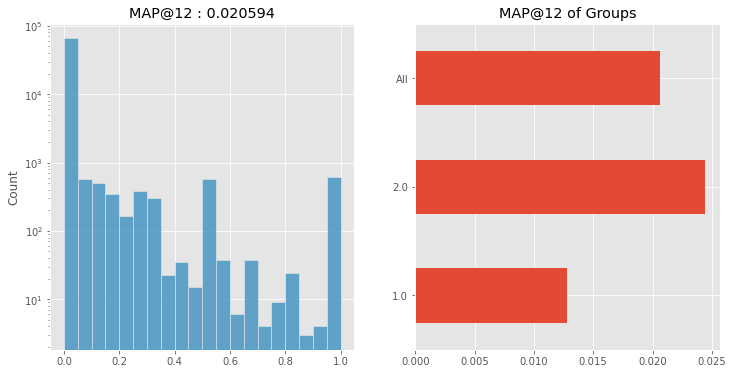

In [15]:
predicted = sub['last_purchase'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, index='Last Purchase', ignore=(val_week == 105))
#Last Purchase	0.012392	0.023801	0.020029	26.9
#Last Purchase	0.012807	0.024439	0.020594	28.7
#Last Purchase	0.011057	0.020228	0.017196	14.2
#Last Purchase	0.010913	0.020194	0.017126	14.2 item2vec
#Last Purchase	0.012333	0.023044	0.019503	21.4

### 購入したアイテムの他の色（６日前まで）

In [16]:
init_date = last_date - dt.timedelta(days=6)
#init_date = last_date - dt.timedelta(days=14)
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .groupby(['article_id']).t_dat.count().reset_index()
adf = pd.read_parquet('../input/hm-parquets-of-datasets/articles.parquet')
adf = adf.merge(train, on='article_id', how='left').rename(columns={'t_dat':'ct'})\
    .sort_values('ct', ascending=False).query('ct > 0')

map_to_col = defaultdict(list)
for aid in adf.article_id.tolist():
    map_to_col[aid] = list(filter(lambda x: x != aid, adf[adf.product_code == aid // 1000].article_id.tolist()))[:1]

def map_to_variation(s):
    f = lambda item: iter_to_str(map_to_col[int(item)])
    return ' '.join(map(f, s.split()))
sub['other_colors'] = sub['last_purchase'].fillna('').apply(map_to_variation)

In [17]:
# # 11日間の売れた商品リストに入っていないアイテムは削除する
init_date = last_date - dt.timedelta(days=11)
sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())

sub['other_colors'] = sub['other_colors'].apply(prune, ok_set=sold_set)

# l = []
# for i in tqdm(range(len(sub))) :
#     itms = sub['last_purchase'][i].split(" ")
#     t = set()
#     for e in itms:
# #         print(e)
#         if e == "" : continue
#         if int(e) not in sold_set : continue
#         t.add(e)
# #     break
#     l.append(" ".join(list(t)))

# sub['last_purchase'] = l

In [18]:
if use_item2vec:
    sub['other_colors'] = sort_item2vec('other_colors', max_n=6)

In [19]:
# sub['other_colors'] = cut_items('other_colors', n=2)

Fill Rate =  14.799999999999999


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8


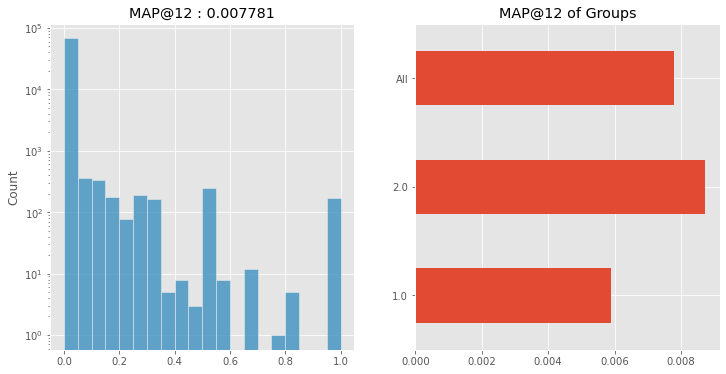

In [20]:
predicted = sub['other_colors'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Other Colors', ignore=(val_week == 105))
#0.008075(6) -> 0.007619(3) -> 0.007058(2) -> 0.005448(1)

### 人気商品 ：年齢層、オンライン／オフライン（４日前まで）グループは1,2,na<-1

In [21]:
# cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
# cdf.fashion_news_frequency.unique()
# cdf.head()

In [22]:
cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
cdf = cdf[['customer_id','age','attribute']]
#listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
listBin = [-1, 19, 34, 49, 119]
#cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str).str.cat(cdf['attribute'].astype(str))
#cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str).str.cat(cdf['attribute'].astype(str))
#cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str)
cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str)
cdf = cdf.drop('age', axis=1)
cdf = cdf.drop('attribute', axis=1)
cdf['cust_feature'].unique()

array(['(46.0, 51.0]', '(23.0, 25.0]', '(51.0, 57.0]', '(-1.001, 20.0]',
       '(31.0, 38.0]', '(28.0, 31.0]', '(57.0, 99.0]', '(38.0, 46.0]',
       '(25.0, 28.0]', '(20.0, 23.0]'], dtype=object)

In [23]:
# # 4日間の売れた商品リスト
# init_date = last_date - dt.timedelta(days=4)
# sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())
# len(sold_set)

In [24]:
init_date = last_date - dt.timedelta(days=5 - 1)
group_df = pd.concat([cid, group.group.fillna(1)], axis=1) # grouping can be changed
group_df = group_df.merge(cdf, on='customer_id', how='right')
group_df.columns = ['customer_id', 'group', 'cust_feature']
group_df['cust_feature'] = group_df['group'].astype(str).str.cat(group_df['cust_feature'])
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .merge(group_df, on='customer_id', how='left')\
    .groupby(['cust_feature', 'article_id']).t_dat.count().reset_index()

items = defaultdict(str)
for g in train.cust_feature.unique():
#    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:30])
    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:20])

sub['trend_items'] = group_df.cust_feature.map(items)

In [25]:
if use_item2vec:
    #normal = "0706016001 0706016002 0372860001 0610776002 0759871002 0464297007 0372860002 0610776001 0399223001 0706016003 0720125001 0156231001"
    sub['trend_items'] = sort_item2vec('trend_items', max_n=12)

Fill Rate =  100.0


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0


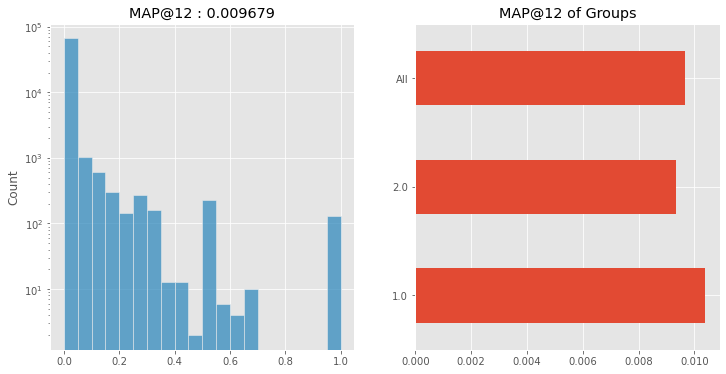

In [26]:
predicted = sub['trend_items'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Trend Items', ignore=(val_week == 105))
#0.012127 12, 0.012550 15, 0.013163 20  0.009679

### 人気商品 ：属性、~年齢層（大まかな）~、オンライン／オフライン（４日前まで）グループは1,2,na<-1

In [27]:
cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
cdf = cdf[['customer_id','age','attribute']]
#listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
listBin = [-1, 19, 40, 119]
#cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str).str.cat(cdf['attribute'].astype(str))
cdf['cust_feature'] = cdf['attribute'].astype(str)
cdf = cdf.drop('age', axis=1)
cdf = cdf.drop('attribute', axis=1)
cdf['cust_feature'].unique()

array(['Woman', 'Sports-person', 'Young', 'Have-kids', 'Man', 'None'],
      dtype=object)

In [28]:
# # 4日間の売れた商品リスト
# init_date = last_date - dt.timedelta(days=4)
# sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())
# len(sold_set)

In [29]:
init_date = last_date - dt.timedelta(days=5 - 1)
group_df = pd.concat([cid, group.group.fillna(1)], axis=1) # grouping can be changed
group_df = group_df.merge(cdf, on='customer_id', how='right')
group_df.columns = ['customer_id', 'group', 'cust_feature']
group_df['cust_feature'] = group_df['group'].astype(str).str.cat(group_df['cust_feature'])
train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .merge(group_df, on='customer_id', how='left')\
    .groupby(['cust_feature', 'article_id']).t_dat.count().reset_index()

items = defaultdict(str)
for g in train.cust_feature.unique():
#    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:30])
    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:20])

sub['trend_items2'] = group_df.cust_feature.map(items)

In [30]:
if use_item2vec:
    sub['trend_items2'] = sort_item2vec('trend_items2', max_n=12)

Fill Rate =  99.3


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3


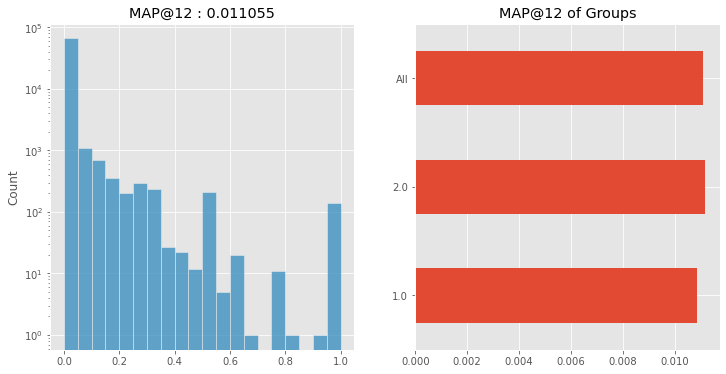

In [31]:
predicted = sub['trend_items2'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Trend Items2', ignore=(val_week == 105))

### 人気商品 ： Active（４日前まで）グループは1,2,na<-1

In [32]:
# cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
# cdf = cdf[['customer_id','attribute','Active']]
# cdf['cust_feature'] = cdf['attribute'].astype(str).str.cat(cdf['Active'].astype(str))
# cdf = cdf.drop('attribute', axis=1)
# cdf['cust_feature'].unique()

In [33]:
# # 4日間の売れた商品リスト
# init_date = last_date - dt.timedelta(days=4)
# sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())
# len(sold_set)

In [34]:
# init_date = last_date - dt.timedelta(days=5 - 1)
# group_df = pd.concat([cid, group.group.fillna(1)], axis=1) # grouping can be changed
# group_df = group_df.merge(cdf, on='customer_id', how='right')
# group_df.columns = ['customer_id', 'group', 'Active', 'cust_feature']
# group_df['cust_feature'] = group_df['group'].astype(str).str.cat(group_df['cust_feature'])

# train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
#     .merge(group_df, on='customer_id', how='left')\
#     .groupby(['cust_feature', 'article_id']).t_dat.count().reset_index()

# items = defaultdict(str)
# for g in train.cust_feature.unique():
# #    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:30])
#     items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:20])

# sub['trend_active'] = group_df.cust_feature.map(items)
# sub['trend_active'] = sub['trend_active'].fillna("")

In [35]:
# cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
# cdf = cdf[cdf['Active'] == 1]
# cdf = cdf[['customer_id','attribute']]
# cdf.columns = ['customer_id', 'cust_feature']
# cdf['cust_feature'].unique()

cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
cdf = cdf[['customer_id','age','attribute','Active']]
#listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
listBin = [-1, 19, 34, 49, 119]
cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str).str.cat(cdf['attribute'].astype(str))#.str.cat(cdf['Active'].astype(str))
#cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str).str.cat(cdf['attribute'].astype(str))
#cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str)
#cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str)
cdf = cdf.drop('age', axis=1)
cdf = cdf.drop('attribute', axis=1)
cdf = cdf.drop('Active', axis=1)

cdf['cust_feature'].unique()

array(['(34, 49]Woman', '(19, 34]Woman', '(49, 119]Sports-person',
       '(49, 119]Woman', nan, '(19, 34]Young', '(19, 34]Have-kids',
       '(19, 34]Man', '(34, 49]Man', '(-1, 19]Woman', '(34, 49]Have-kids',
       '(49, 119]Young', '(49, 119]Man', '(19, 34]None',
       '(34, 49]Sports-person', '(49, 119]Have-kids', '(-1, 19]Young',
       '(19, 34]Sports-person', '(34, 49]Young', '(-1, 19]Sports-person',
       '(-1, 19]Man', '(34, 49]None', '(49, 119]None',
       '(-1, 19]Have-kids', '(-1, 19]None'], dtype=object)

In [36]:
# # 4日間の売れた商品リスト
# init_date = last_date - dt.timedelta(days=4)
# sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())
# len(sold_set)

In [37]:
init_date = last_date - dt.timedelta(days=5 - 1)
group_df = pd.concat([cid, group.group.fillna(1)], axis=1) # grouping can be changed
group_df = group_df.merge(cdf, on='customer_id', how='left')
group_df.columns = ['customer_id', 'group', 'cust_feature']
group_df['cust_feature'] = group_df['group'].astype(str).str.cat(group_df['cust_feature'])

train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .merge(group_df, on='customer_id', how='left')\
    .groupby(['cust_feature', 'article_id']).t_dat.count().reset_index()

items = defaultdict(str)
for g in train.cust_feature.unique():
    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:20])

sub['trend_ageatt'] = group_df.cust_feature.map(items)
sub['trend_ageatt'] = sub['trend_ageatt'].fillna("")

In [38]:
if use_item2vec:
    sub['trend_ageatt'] = sort_item2vec('trend_ageatt', max_n=12)

Fill Rate =  98.1


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3
Trend age+attr,0.011482,0.010881,0.011080,98.1


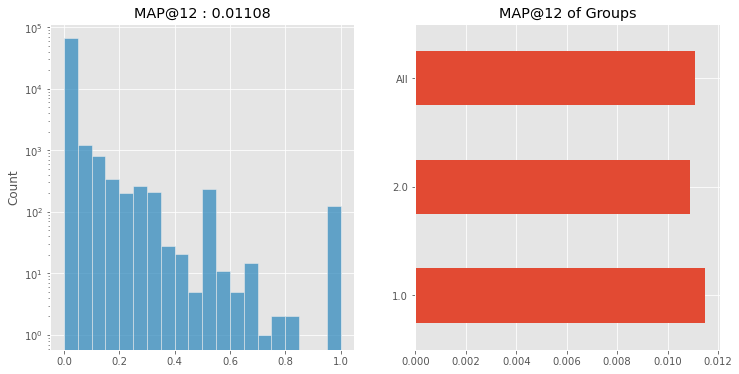

In [39]:
predicted = sub['trend_ageatt'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Trend age+attr', ignore=(val_week == 105))

### Woman 

In [40]:
# cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
# #cdf = cdf[cdf['fashion_news_frequency'] >= 1]
# cdf = cdf[cdf['attribute'] == 'Woman']
# # cdf = cdf[cdf['Active'] == 1]
# cdf

In [41]:
cdf = pd.read_parquet('../input/handmitem2vec/customers.parquet')
#cdf = cdf[cdf['fashion_news_frequency'] >= 1]
cdf = cdf[cdf['attribute'] == 'Woman']
# cdf = cdf[cdf['Active'] == 1]
cdf = cdf[['customer_id','age']]
# cdf.columns = ['customer_id', 'cust_feature']
# cdf['cust_feature'].unique()
#listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
listBin = [-1, 19, 34, 49, 119]
#cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str).str.cat(cdf['Active'].astype(str))
#cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str).str.cat(cdf['attribute'].astype(str))
cdf['cust_feature'] = pd.cut(cdf['age'], listBin).astype(str)
#cdf['cust_feature'] = pd.qcut(cdf['age'], 10).astype(str)
cdf = cdf.drop('age', axis=1)
cdf['cust_feature'].unique()

array(['(34, 49]', '(19, 34]', '(49, 119]', '(-1, 19]', nan], dtype=object)

In [42]:
# # 4日間の売れた商品リスト
# init_date = last_date - dt.timedelta(days=4)
# sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())
# len(sold_set)

In [43]:
init_date = last_date - dt.timedelta(days=5 - 1)
group_df = pd.concat([cid, group.group.fillna(1)], axis=1) # grouping can be changed
group_df = group_df.merge(cdf, on='customer_id', how='left')
group_df.columns = ['customer_id', 'group', 'cust_feature']
group_df['cust_feature'] = group_df['group'].astype(str).str.cat(group_df['cust_feature'])

train = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].copy()\
    .merge(group_df, on='customer_id', how='left')\
    .groupby(['cust_feature', 'article_id']).t_dat.count().reset_index()

items = defaultdict(str)
for g in train.cust_feature.unique():
    items[g] = iter_to_str(train.loc[train.cust_feature == g].sort_values('t_dat', ascending=False).article_id.tolist()[:20])

sub['trend_woman'] = group_df.cust_feature.map(items)
sub['trend_woman'] = sub['trend_woman'].fillna("")

In [44]:
if use_item2vec:
    sub['trend_woman'] = sort_item2vec('trend_woman', max_n=12)

Fill Rate =  74.8


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3
Trend age+attr,0.011482,0.010881,0.011080,98.1
Trend Woman,0.010283,0.008410,0.009029,74.8


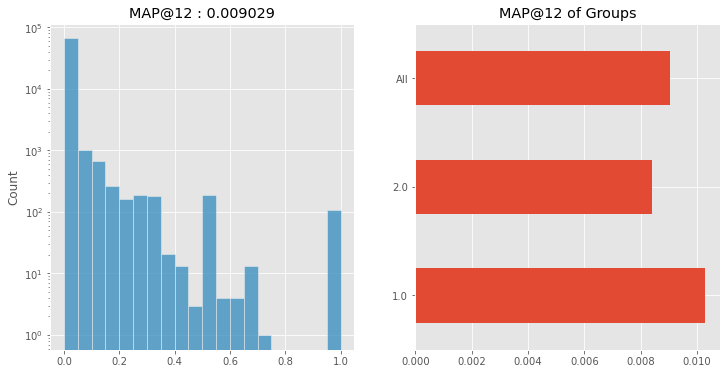

In [45]:
predicted = sub['trend_woman'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Trend Woman', ignore=(val_week == 105))

### item2vecだけでの予測

In [46]:
# # 11日間の売れた商品リスト
# init_date = last_date - dt.timedelta(days=11)
# sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())

In [47]:
# l = []
# for i in tqdm(range(len(sub))) :
#     cid = sub.iloc[i]['customer_id']
#     if cid not in cust_buy :
#         l.append("")
#         continue
#     item = cust_buy[cid].split(" ")
#     r = model.wv.most_similar(item, topn=20)
#     t = []
#     for x, p in r :
#         if int(x) in sold_set :
#             t.append(x)
#     l.append(" ".join(t[:12]))
# #     if i == 10 : break

# sub['item2vec'] = l

In [48]:
# predicted = sub['item2vec'].apply(lambda s: [] if pd.isna(s) else s.split())
# score = validation(actual, predicted, grouping, score, index='item2vec', ignore=(val_week == 105))

In [49]:
# cnt = 0
# for i in range(len(actual)) :
    
#     if len(actual[i]) != 0 :
#         cid = sub['customer_id'][i]
# #         print(i, cid)
# #         print(actual[i])
#         if cid not in cust_buy : continue
#         item = cust_buy[cid].split(" ")
# #         print(item[-1])
#         r = model.wv.most_similar(item, topn=12)
#         t = []
#         for x, p in r :
#             if x in actual[i] :
#                 print("HIT", i, x)
#                 cnt+=1
#             if int(x) in sold_set :
#                 t.append(x)
# #         print(r, t)
# #         print(t)
# #         cnt+=1
# #         print("-"*40)
        
#     if i == 100000: break
# cnt/100000

## kangol

In [50]:
# articles_df = pd.read_csv("../input/h-and-m-personalized-fashion-recommendations/articles.csv",dtype=str, encoding='utf8')

In [51]:
# xHM = []
# for i, e in enumerate(articles_df['detail_desc'].fillna("")) :
#     if 'Kangol x H&M' in e:
#         print(articles_df.iloc[i]['article_id'], e)
#         xHM.append(articles_df.iloc[i]['article_id'])
# #     elif 'Whooli Chen x H&M' in e :
# #         print(articles_df.iloc[i]['article_id'], e)
# #         xHM.append(articles_df.iloc[i]['article_id'])
        
# xHM


In [52]:
# ll = " ".join(xHM[-12:])
# sub['kangol'] = [ll for _ in range(len(sub))]

In [53]:
# sub['kangol'] = sort_item2vec('kangol', max_n=12)

In [54]:
# predicted = sub['kangol'].apply(lambda s: [] if pd.isna(s) else s.split())
# score = validation(actual, predicted, grouping, score, index='kangol', ignore=(val_week == 105))

In [55]:
#sub.head()

## 数年間定番アイテム

In [56]:
# dayly sale

# 2018
day = 20
start = dt.datetime(2018,9,day,0,0)
end = dt.datetime(2018,9,day,23,59)
x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()

popular = set(x)
print(len(x))

for day in range(20, 31, 1) :
    start = dt.datetime(2018,9,day,0,0)
    end = dt.datetime(2018,9,day,23,59)
    x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()
    popular &= set(x)
    print(start, end, len(x), len(popular))

# 2019
for day in range(15, 30, 1) :
    start = dt.datetime(2019,9,day,0,0)
    end = dt.datetime(2019,9,day,23,59)
    x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()
    popular &= set(x)
    print(start, end, len(x), len(popular))

# 2020
for day in range(15, 23, 1) :
    start = dt.datetime(2020,9,day,0,0)
    end = dt.datetime(2020,9,day,23,59)
    x = df.loc[(df.t_dat >= start) & (df.t_dat <= end)].article_id.tolist()
    popular &= set(x)
    print(start, end, len(x), len(popular))



48399
2018-09-20 00:00:00 2018-09-20 23:59:00 48399 11542
2018-09-21 00:00:00 2018-09-21 23:59:00 47543 7812
2018-09-22 00:00:00 2018-09-22 23:59:00 17635 4457
2018-09-23 00:00:00 2018-09-23 23:59:00 52230 3910
2018-09-24 00:00:00 2018-09-24 23:59:00 45984 3556
2018-09-25 00:00:00 2018-09-25 23:59:00 43857 3272
2018-09-26 00:00:00 2018-09-26 23:59:00 48224 3121
2018-09-27 00:00:00 2018-09-27 23:59:00 44261 2970
2018-09-28 00:00:00 2018-09-28 23:59:00 66900 2898
2018-09-29 00:00:00 2018-09-29 23:59:00 141700 2857
2018-09-30 00:00:00 2018-09-30 23:59:00 38043 2590
2019-09-15 00:00:00 2019-09-15 23:59:00 31112 499
2019-09-16 00:00:00 2019-09-16 23:59:00 33716 356
2019-09-17 00:00:00 2019-09-17 23:59:00 37008 312
2019-09-18 00:00:00 2019-09-18 23:59:00 39063 290
2019-09-19 00:00:00 2019-09-19 23:59:00 36491 275
2019-09-20 00:00:00 2019-09-20 23:59:00 31508 257
2019-09-21 00:00:00 2019-09-21 23:59:00 20542 234
2019-09-22 00:00:00 2019-09-22 23:59:00 33950 220
2019-09-23 00:00:00 2019-09-23 

In [57]:
from tqdm import tqdm
from collections import defaultdict

l = []
for i in tqdm(range(len(sub))):
    c_id = sub['customer_id'][i]
    if c_id not in cust_buy :
        l.append("")
        continue
        
    t = defaultdict(int)
    li = cust_buy[c_id].split(" ")
    #li.reverse()
#     print(cid, li)
    for e in li:
        if int(e) in popular :
            t[e] += 1
#     if len(t) != 0 : print(cid, t)
#     print(t)
    ti = []
    for e in t :
        ti.append([t[e],e])
    ti.sort(reverse=True)
    ti = list(map(lambda x: x[1], ti)) 
    l.append(" ".join(ti))
#     if i == 100: break
sub['popular_items'] = l 

100%|██████████| 1371980/1371980 [00:11<00:00, 117292.63it/s]


Fill Rate =  3.4000000000000004


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3
Trend age+attr,0.011482,0.010881,0.011080,98.1
Trend Woman,0.010283,0.008410,0.009029,74.8
Popular Items,0.003576,0.002567,0.002901,3.4


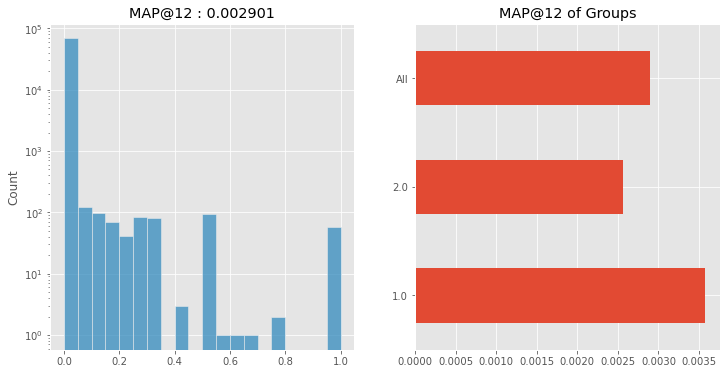

In [58]:
predicted = sub['popular_items'].apply(lambda s: [] if pd.isna(s) else s.split())
#score = validation(actual, predicted, grouping, index='anytime popular', ignore=(val_week == 105))
score = validation(actual, predicted, grouping, score, index='Popular Items', ignore=(val_week == 105))
#Popular Items	0.003576	0.002567	0.002901	3.4

## 嗜好の似たカスタマーが購入したもの

In [59]:
if val_week == 105 :
    uucf = pd.read_csv('../input/uucf-2-0814.csv')
else :
    print("104")
#    uucf = pd.read_csv('../input/uucf104.csv')
    uucf = pd.read_csv('../input/uucf104-2-0814.csv')

uucf.head(10)

104


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,0706016001 0706016002 0372860001 0610776002 07...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,"['0448509014', '0719530003', '0448509018', '04..."
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,0706016001 0706016002 0372860001 0610776002 07...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,0706016001 0706016002 0372860001 0610776002 07...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,0706016001 0706016002 0372860001 0610776002 07...


In [60]:
l = []
for i in tqdm(range(len(uucf))) :
    s = uucf['prediction'][i]
    if s[0] == '[' :
        s = " ".join(eval(s))
    else : s = ""
    l.append(s)
sub['uucf'] = l
del uucf

100%|██████████| 1371980/1371980 [00:06<00:00, 226707.89it/s]


Fill Rate =  13.600000000000001


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3
Trend age+attr,0.011482,0.010881,0.011080,98.1
Trend Woman,0.010283,0.008410,0.009029,74.8
Popular Items,0.003576,0.002567,0.002901,3.4
uucf Items,0.008319,0.015218,0.012937,13.6


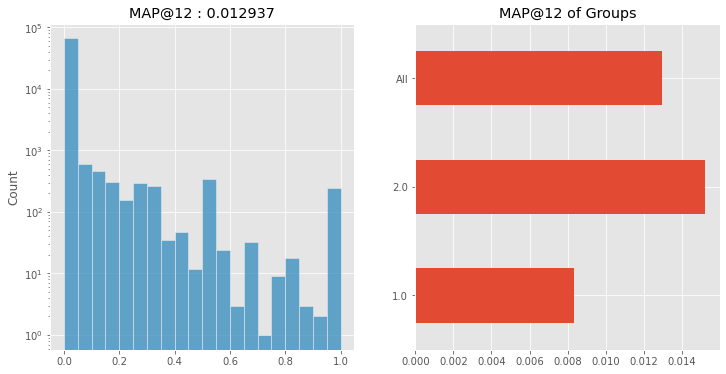

In [61]:
predicted = sub['uucf'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='uucf Items', ignore=(val_week == 105))
# 8352 9737 8653
# 0.011568

## another uucf

In [62]:
from collections import defaultdict

def remove_(in_df, num = 10000) :
    m = defaultdict(int)
    target, tmax = "", 0
    for i in tqdm(range(len(in_df))) :
        p = in_df['prediction'][i]
        m[p] += 1
        if m[p] > tmax :
            tmax = m[p]
            target = p

    l = []
    skip = 0
    for i in tqdm(range(len(in_df))) :
        p = in_df['prediction'][i]
        if m[p] >= num:
            l.append("")
            skip += 1
        else :
            l.append(p)
    print("skip = ", skip)
    return l

In [63]:
if val_week == 105 :
    uucf = pd.read_csv('../input/cf.csv').fillna("")
else :
    print("104")
#    uucf = pd.read_csv('../input/uucf104.csv')
    uucf = pd.read_csv('../input/cf104.csv').fillna("")

# uucf['prediction'] = remove_(uucf, 10)

sub['uucf2'] = uucf['prediction']
display(uucf.head(20))
del uucf

104


,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0762846031 0568601006 0568601044 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152002 0730683050 0791587015 0791587001 07...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,0448509014 0448509018 0719530003 0760084003 04...
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,


Fill Rate =  23.7


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3
Trend age+attr,0.011482,0.010881,0.011080,98.1
Trend Woman,0.010283,0.008410,0.009029,74.8
Popular Items,0.003576,0.002567,0.002901,3.4
uucf Items,0.008319,0.015218,0.012937,13.6
uucf2 Items,0.008372,0.013147,0.011568,23.7


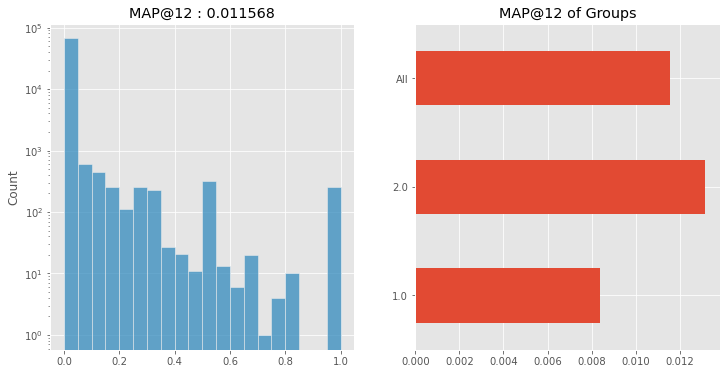

In [64]:
predicted = sub['uucf2'].apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='uucf2 Items', ignore=(val_week == 105))
# 8352 9737 8653
# 0.011568

In [65]:
sub

,customer_id,prediction,last_purchase,other_colors,trend_items,trend_items2,trend_ageatt,trend_woman,popular_items,uucf,uucf2
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0706016001 0706016002 0372860001 0610776002 07...,0568601043,0568601006,0918522001 0924243001 0919273002 0914805002 07...,0924243001 0865799006 0909370001 0923758001 09...,0909370001 0918525001 0919273002 0924243001 09...,0909370001 0918525001 0919273002 0924243001 09...,0568601006,,0762846031 0568601006 0568601044 0568601007 05...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0706016001 0706016002 0372860001 0610776002 07...,0826211002,,0865799006 0809238001 0924243001 0909370001 08...,0924243001 0865799006 0909370001 0923758001 09...,0865799006 0909370001 0924243001 0809238001 08...,0865799006 0909370001 0924243001 0809238001 08...,0673677002 0658298001,,
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0706016001 0706016002 0372860001 0610776002 07...,0794321007,0794321011,0865799006 0809238001 0924243001 0909370001 08...,0924243001 0865799006 0909370001 0923758001 09...,0865799006 0909370001 0924243001 0809238001 08...,0865799006 0909370001 0924243001 0809238001 08...,,,
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0706016001 0706016002 0372860001 0610776002 07...,0742079001 0732413001,,0924243001 0923758001 0865799006 0751471001 09...,0918292001 0918292004 0912204001 0730683052 07...,0794321007 0805000008 0653275006 0653275035 09...,,,,
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0706016001 0706016002 0372860001 0610776002 07...,0791587015 0927530004 0730683050 0896152002,0791587001 0927530006 0730683062 0896152001,0924243001 0923758001 0865799006 0751471001 09...,0924243001 0865799006 0909370001 0923758001 09...,0924243001 0923758001 0918522001 0865799006 09...,0924243001 0923758001 0918522001 0865799006 09...,,,0896152002 0730683050 0791587015 0791587001 07...
...,...,...,...,...,...,...,...,...,...,...,...
1371975,ffffbbf78b6eaac697a8a5dfbfd2bfa8113ee5b403e474...,0706016001 0706016002 0372860001 0610776002 07...,0713997002 0720125039 0740922009 0791587007 08...,0713997100 0720125007 0740922001 0791587015 08...,0865799006 0809238001 0924243001 0909370001 08...,0924243001 0865799006 0909370001 0923758001 09...,0865799006 0909370001 0924243001 0809238001 08...,0865799006 0909370001 0924243001 0809238001 08...,0253448003,0804992033 0720125039 0740922009 0557599022 07...,0557599022 0822344001 0822311001 0887681003 08...
1371976,ffffcd5046a6143d29a04fb8c424ce494a76e5cdf4fab5...,0706016001 0706016002 0372860001 0610776002 07...,0762846031 0853654012 0624486088 0853654002 07...,0762846027 0853654001 0624486001 0759871025,0448509014 0918522001 0865799006 0809238005 09...,0448509014 0715624001 0706016001 0706016003 07...,0448509014 0706016001 0715624001 0761406001 08...,,0624486001 0507909001,,0762846031 0762846027 0762846026 0889460003 07...
1371977,ffffcf35913a0bee60e8741cb2b4e78b8a98ee5ff2e6a1...,0706016001 0706016002 0372860001 0610776002 07...,0762846027 0689365050 0794819001 0884081001,0762846031 0689365045 0794819003 0884081002,0448509014 0918522001 0865799006 0809238005 09...,0924243001 0865799006 0909370001 0923758001 09...,0865799006 0909370001 0924243001 0809238001 08...,0865799006 0909370001 0924243001 0809238001 08...,0636323002,0762846027 0689365050 0762846031 0884081001 07...,0762846027 0762846026 0762846031 0889460003 07...
1371978,ffffd7744cebcf3aca44ae7049d2a94b87074c3d4ffe38...,0706016001 0706016002 0372860001 0610776002 07...,0882810001,0882810004,0448509014 0685814003 0715624001 0918522001 08...,0448509014 0715624001 0706016001 0706016003 07...,0715624001 0448509014 0706016001 0903420001 08...,,,,


In [66]:
# # 11日間の売れた商品リスト
# init_date = last_date - dt.timedelta(days=11)
# last_sell = df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)]
# sell =  last_sell.groupby('customer_id')\
#      .article_id.apply(iter_to_str).reset_index()\
#      .merge(cid, on='customer_id', how='right').article_id.fillna('')

In [67]:
# last_buy = defaultdict(list)
# for i in tqdm(range(len(sub))) :
#     x = set(sell[i].split(" ")) - set('')
#     last_buy[sub['customer_id'][i]] = x

In [68]:
# import pickle
# with open("../input/handmitem2vec/cust_similar.pkl", "rb") as f :
#     cust_similar = pickle.load(f)
# len(cust_similar)

In [69]:
# l = []
# for i in tqdm(range(len(sub))): 
#     c = sub['customer_id'][i]
#     x = cust_similar[c]
#     y = set()
#     if c in cust_buy :
#         y = set(cust_buy[c].split(" "))
#     t = []
#     for e, _ in x :
#         if e in y : continue # 既に購入しているものはスキップ
#         if last_buy[e] == {''}: continue
#         t += last_buy[e]
#     l.append(" ".join(set(t)))

In [70]:
# sub['similar_customers'] = l

In [71]:
#if use_item2vec:
#    sub['similar_customers'] = sort_item2vec('similar_customers', max_n=12)

In [72]:
# predicted = sub['similar_customers'].apply(lambda s: [] if pd.isna(s) else s.split())
# score = validation(actual, predicted, grouping, score, index='Similar Customers', ignore=(val_week == 105))

## save

In [73]:
if is_save :
    print("SAVE.....")
    if val_week == 105: 
        sub.to_parquet('submission_all.parquet', index=False)
    else :
        sub.to_parquet('submission_all_104.parquet', index=False)

## memory clear

In [74]:
# import gc
# del model
# del cust_buy
# gc.collect()

### 予測をブレンド

In [75]:
# 11日間の売れた商品リスト
init_date = last_date - dt.timedelta(days=2)
sold_set = set(df.loc[(df.t_dat >= init_date) & (df.t_dat <= last_date)].article_id.tolist())

Fill Rate =  100.0


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3
Trend age+attr,0.011482,0.010881,0.011080,98.1
Trend Woman,0.010283,0.008410,0.009029,74.8
Popular Items,0.003576,0.002567,0.002901,3.4
uucf Items,0.008319,0.015218,0.012937,13.6
uucf2 Items,0.008372,0.013147,0.011568,23.7
Prediction,0.020816,0.031244,0.027797,100.0


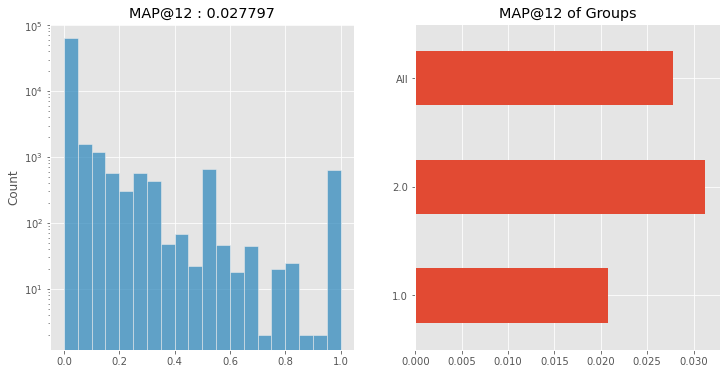

In [76]:
# 11日間に販売実績のある商品だけ対象
# targets = ['last_purchase', 'popular_items', 'other_colors', 
#            'trend_woman', 'trend_ageatt', 'trend_items2', 'trend_items' ]
# weights = [1000, 5, 10, 
#            2, 2, 1.5, 1]


targets = ['last_purchase', 'other_colors', 'popular_items', 
           'trend_woman', 'trend_ageatt', 'trend_items2',  'uucf', 'trend_items' ]
weights = [1000, 10, 5, 
           1, 1, 1.3, 3, 0.5]

# targets = ['last_purchase', 'uucf', 'other_colors', 'popular_items', 
#            'trend_woman', 'trend_ageatt', 'trend_items2', 'trend_items' ]
# weights = [1000, 10, 10, 10, 
#            1, 1, 1.3, 0.5]
targets = ['last_purchase', 'other_colors', 'popular_items', 'uucf', 'uucf2',
           'trend_woman', 'trend_ageatt', 'trend_items2', 'trend_items' ]
weights = [10, 2 ,2, 2, 2, 
           1, 1, 1.3, 0.5]


sub['prediction'] = sub[targets].apply(blend, w=weights, axis=1, k=100).apply(prune, ok_set=sold_set)
predicted = sub.prediction.apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Prediction', ignore=(val_week == 105))

#score が定義されていないとき（loadした時）
#score = validation(actual, predicted, grouping, index='Prediction', ignore=(val_week == 105))


#Prediction	0.019646	0.031350	0.027481	100.0 [100, 5, 10, 2, 1] without itemvec
#Prediction	0.020333	0.032050	0.028177	100.0 [100, 5, 10, 2, 1] with itemvec  

#Prediction	0.019675	0.031394	0.027520	100.0 [100, 5, 10, 2, 1, 2]
#Prediction	0.020852	0.032008	0.028320	100.0 [100, 5, 10, 2, 1, 2] test

#Prediction	0.019834	0.031329	0.027529	100.0
# 7 predictions with item2vec 
# first 3-items : 22754 23247 
#       4-items : 15229 15732 15836 15873
#     all items : 28536 
# 0.028359 0.028392 28464 0.028675 0.029269

Fill Rate =  40.9


,1.0,2.0,All,Fill
Last Purchase,0.012807,0.024439,0.020594,28.7
Other Colors,0.005881,0.008720,0.007781,14.8
Trend Items,0.010388,0.009330,0.009679,100.0
Trend Items2,0.010851,0.011156,0.011055,99.3
Trend age+attr,0.011482,0.010881,0.011080,98.1
Trend Woman,0.010283,0.008410,0.009029,74.8
Popular Items,0.003576,0.002567,0.002901,3.4
uucf Items,0.008319,0.015218,0.012937,13.6
uucf2 Items,0.008372,0.013147,0.011568,23.7
Prediction,0.020816,0.031244,0.027797,100.0


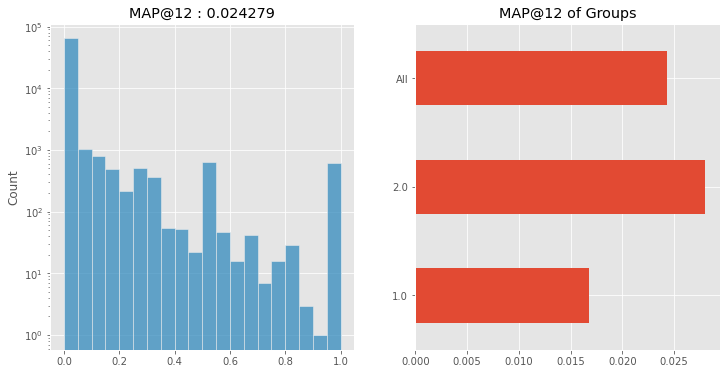

In [77]:
targets = ['last_purchase', 'other_colors', 'popular_items', 'uucf', 'uucf2']
weights = [10, 2 ,2, 2, 2]

sub['customer'] = sub[targets].apply(blend, w=weights, axis=1, k=100).apply(prune, ok_set=sold_set)
predicted = sub.customer.apply(lambda s: [] if pd.isna(s) else s.split())
score = validation(actual, predicted, grouping, score, index='Customer', ignore=(val_week == 105))

In [78]:
# targets = ['trend_woman', 'trend_ageatt', 'trend_items2', 'trend_items']
# weights = [1,1,1,1]
# sub['trend'] = sub[targets].apply(blend, w=weights, axis=1, k=100).apply(prune, ok_set=sold_set)
# predicted = sub.trend.apply(lambda s: [] if pd.isna(s) else s.split())
# score = validation(actual, predicted, grouping, score, index='Trend', ignore=(val_week == 105))

In [79]:
# targets = ['customer', 'trend']
# weights = [4,1]
# sub['prediction'] = sub[targets].apply(blend, w=weights, axis=1, k=100).apply(prune, ok_set=sold_set)
# predicted = sub.prediction.apply(lambda s: [] if pd.isna(s) else s.split())
# score = validation(actual, predicted, grouping, score, index='Prediction', ignore=(val_week == 105))

In [80]:
len(sub['prediction'][0].split())
#sns.barplot(data=score, x='All', y=score.index)

12

In [81]:
if val_week == 105: sub[['customer_id', 'prediction']].to_csv('submission.csv', index=False)

In [82]:
for i in tqdm(range(len(sub))) :
    x = sub['prediction'][i].split(" ")
    if len(x) != 12 :
        print(sub['customer_id'][i], x)
        break

100%|██████████| 1371980/1371980 [00:04<00:00, 332237.45it/s]
